## <font color='darkblue'>Preface</font>
([article source](https://towardsdatascience.com/feature-importance-with-neural-network-346eb6205743)) <font size='3ptx'>**Make Machine Learning easy interpretable providing variable relationships explanation**</font>

**One of the best challenges in Machine Learning tends to let the model speak themself**. It not also is important to develop a strong solution with great predicting power, but also in a lot of business applications is interesting to know how the model provides these results: **which variables are engaged the most, the presence of correlations, the possible causation relationships and so on.**

These needs made the Tree-based model a good weapon in this field. They are scalable and permits to compute variable explanation very easy. Every software provides this option and each of us has at least once tried to compute the variable importance report with Random Forest or similar. <font color='darkred'>**With Neural Net this kind of benefit is considered taboo. Neural Network is often seen as a black box, from which it is very difficult to extract useful information for another purpose like feature explanations.**</font>

**In this post, I try to provide an elegant and clever solution, that with few lines of codes, permits you to squeeze your Machine Learning Model and extract as much information as possible**, in order to provide feature importance, individuate the significant correlations and try to explain causation.

## <font color='darkblue'>THE DATASET</font>
Given a real dataset, we try to investigate which factors influence the final prediction performances. To achieve this aim we took data from [**UCI Machine Learning Repository**](https://archive.ics.uci.edu/ml/index.php). The [privileged dataset was the Combined Cycle Power Plant Dataset](https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant), where were collected 6 years of data when the power plant was set to work with full load. Features consist of hourly average variables: `Ambient Temperature` (AT), `Ambient Pressure` (AP), `Relative Humidity` (RH) and `Exhaust Vacuum` (V) to predict the `net hourly electrical energy output` (PE) of the plant.

The variables engaged are related by [Pearson correlation linkages](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) as shown in the matrix below.

In [10]:
# Load dataset from CSV
import pandas as pd

DATA_PATH = "../../datas/CCPP/Folds5x2_pp.csv"

df = pd.read_csv(DATA_PATH)
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


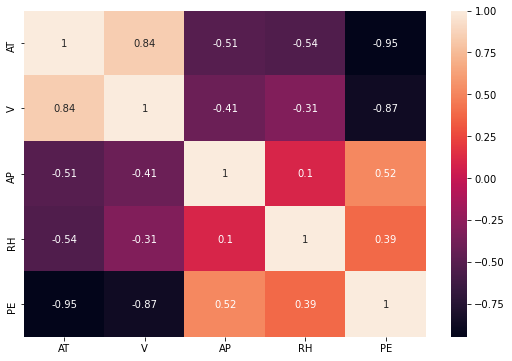

In [13]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [9, 6]
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

## <font color='darkblue'>GRADIENT BOOSTING FEATURE IMPORTANCE</font>
**We start building a simple Tree-based model in order to provide energy output** (PE) **predictions and compute the standard feature importance estimations**. This final step permits us to say more about the variable relationships than a standard correlation index. These numbers summarized the reduction in impurity index over all trees when a particular feature is pointed during internal space partition (<font color='brown'>in training phase</font>). Sklearn applies normalization in order to provide output summable to one. It is also a free result, obtainable indirectly after training.

([<matplotlib.axis.XTick at 0x1e00ed0a240>,
 [Text(0, 0, 'AT'), Text(0, 0, 'V'), Text(0, 0, 'AP'), Text(0, 0, 'RH')])

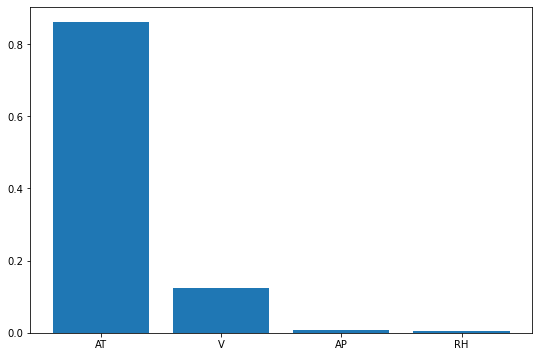

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

X = df.loc[:, df.columns != 'PE']
y = df['PE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb = GradientBoostingRegressor(n_estimators=100)
gb.fit(X_train, y_train.values.ravel())
plt.bar(range(X_train.shape[1]), gb.feature_importances_)
plt.xticks(range(X_train.shape[1]), X_train.columns) # ['AT','V','AP','RH']

This result is easily interpretable and seems to replicate the initial assumption made computing correlations with our target variable (<font color='brown'>last row of correlation matrix</font>): **higher the value, higher is the impact of this particular feature predicting our target.**

Despite the goods results we achieved with our [**Gradient Boosting**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) we don’t want to completely depend by this kind of approach… **We want to generalize the process of computing feature importance, let us free to develop another kind of Machine Learning model with the same flexibility and explainability power; making also a step further: provide evidence of the presence of significant casualty relationship among variables**.

## <font color='darkblue'>PERMUTATION IMPORTANCE</font>
The models identified for our experiment are doubtless Neural Networks for their reputation to be a black box algorithm. In order to demystify this stereotype, **we’ll focus on Permutation Importance. Its easy implementation, combined with its tangible understanding and adaptability, making it a consistent candidate to answer the question: What features have the biggest impact on predictions?**

Permutation importance is calculated after a model has been fitted. So we have only to squeeze it and get what we want. **This method works on a simple principle: If I randomly shuffle a single feature in the data, leaving the target and all others in place, how would that affect the final prediction performances?**

From this random reordering of variables I expect to obtain:
* Less accurate predictions, since the resulting data no longer corresponds to anything observed in the real world;
* Worst performances, from the shuffle of the most important variables. This is because we are corrupting the natural structure of data. If we, with our shuffle, break a strong relationship we’ll compromise what our model has learned during training, resulting in higher errors (<font color='brown'>high error = high importance</font>).

![Image1](images/1.png)
<br/>

Practically speaking this is what’s happened in our real scenario…

We chose an adequate Neural Net structure to model the hourly electrical energy output (EP). Remember to scale also the target variable in a lower range: I classically subtracted mean and divided for standard deviation, this helps the train.

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [24]:
from keras.models import Model
from keras.layers import Dense, Input

inp = Input(shape=(X_train_scaled.shape[1],))
x = Dense(128, activation='relu')(inp)
x = Dense(32, activation='relu')(x)
out = Dense(1)(x)
model = Model(inp, out)
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_scaled, (y_train - y_train.mean())/y_train.std() , epochs=100, batch_size=128 ,verbose=2)

Epoch 1/100
60/60 - 0s - loss: 0.1940
Epoch 2/100
60/60 - 0s - loss: 0.0641
Epoch 3/100
60/60 - 0s - loss: 0.0616
Epoch 4/100
60/60 - 0s - loss: 0.0608
Epoch 5/100
60/60 - 0s - loss: 0.0604
Epoch 6/100
60/60 - 0s - loss: 0.0603
Epoch 7/100
60/60 - 0s - loss: 0.0593
Epoch 8/100
60/60 - 0s - loss: 0.0590
Epoch 9/100
60/60 - 0s - loss: 0.0591
Epoch 10/100
60/60 - 0s - loss: 0.0600
Epoch 11/100
60/60 - 0s - loss: 0.0583
Epoch 12/100
60/60 - 0s - loss: 0.0585
Epoch 13/100
60/60 - 0s - loss: 0.0584
Epoch 14/100
60/60 - 0s - loss: 0.0578
Epoch 15/100
60/60 - 0s - loss: 0.0581
Epoch 16/100
60/60 - 0s - loss: 0.0576
Epoch 17/100
60/60 - 0s - loss: 0.0574
Epoch 18/100
60/60 - 0s - loss: 0.0570
Epoch 19/100
60/60 - 0s - loss: 0.0569
Epoch 20/100
60/60 - 0s - loss: 0.0568
Epoch 21/100
60/60 - 0s - loss: 0.0571
Epoch 22/100
60/60 - 0s - loss: 0.0572
Epoch 23/100
60/60 - 0s - loss: 0.0565
Epoch 24/100
60/60 - 0s - loss: 0.0564
Epoch 25/100
60/60 - 0s - loss: 0.0558
Epoch 26/100
60/60 - 0s - loss: 0.

At the prediction stage, the Gradient Boosting and the Neural Net achieve the same performance in terms of [**Mean Absolute Error**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html), respectively 2.92 and 0.17 (<font color='brown'>remember to reverse predictions</font>):

In [25]:
from sklearn.metrics import mean_absolute_error

gb_y_pred = gb.predict(X_test)

X_test_scaled = scaler.transform(X_test)
y_test_stdzed = (y_test - y_test.mean())/y_test.std()
nn_y_pred = model.predict(X_test_scaled)

In [29]:
print(f"GB MAE={mean_absolute_error(y_test, gb_y_pred):.02f}")

NN_MAE = mean_absolute_error(y_test_stdzed, nn_y_pred)
print(f"NN MAE={NN_MAE:.02f}")

GB MAE=2.87
NN MAE=0.17


At this point, we ended with training and let’s start to randomly sample.

We compute the shuffle of every feature on validation data (<font color='brown'>4 times in total = 4 explicative variables</font>) and provide error estimations at each step; remember to return the data to the original order at every step. Then I plot the MAE we achieved at every shuffle stage as percentage variation from the original MAE.

In [42]:
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = X_test.columns)
X_test_scaled_df.head()

,AT,V,AP,RH
0,1.344993,0.238693,-1.286581,-1.105325
1,0.810959,1.362691,-0.741407,0.264859
2,-0.243724,-0.739004,1.999702,-0.197132
3,-1.363990,-1.015874,2.294299,0.969859
4,1.371761,0.823896,0.621529,-1.730695


In [49]:
X_test_scaled_df['AT'] = X_test_scaled_df['AT'] * 4

In [50]:
X_test_scaled_df.head()

,AT,V,AP,RH
0,5.379972,0.238693,-1.286581,-1.105325
1,3.243836,1.362691,-0.741407,0.264859
2,-0.974896,-0.739004,1.999702,-0.197132
3,-5.455962,-1.015874,2.294299,0.969859
4,5.487046,0.823896,0.621529,-1.730695


In [59]:
mae_diff_dict = {} # key as feature, value as tuple(new_mse, shuffled_pred)
for i, f in enumerate(X_test.columns):
    print(f"Working on feature={f} ({i})")
    X_test_scaled_df[f] = X_test_scaled_df[f] * 4    
    print(X_test_scaled_df.head(1))
    nn_y_pred_shuffled = model.predict(X_test_scaled_df)
    new_mae = mean_absolute_error(nn_y_pred_shuffled, nn_y_pred)
    mae_diff_dict[f] = (abs(new_mae - NN_MAE) * 100 / NN_MAE, nn_y_pred_shuffled)
    X_test_scaled_df[f] = X_test_scaled_df[f] / 4

Working on feature=AT (0)
          AT         V        AP        RH
0  21.519886  0.238693 -1.286581 -1.105325
Working on feature=V (1)
         AT         V        AP        RH
0  5.379972  0.954772 -1.286581 -1.105325
Working on feature=AP (2)
         AT         V        AP        RH
0  5.379972  0.238693 -5.146323 -1.105325
Working on feature=RH (3)
         AT         V        AP        RH
0  5.379972  0.238693 -1.286581 -4.421302


In [61]:
list(map(lambda t: (t[0], t[1][0]), mae_diff_dict.items()))

[('AT', 5938.62453985666),
 ('V', 818.1821894805488),
 ('AP', 1005.2811980847956),
 ('RH', 913.602108377995)]

([<matplotlib.axis.XTick at 0x1e02d433470>,
 [Text(0, 0, 'AT'), Text(0, 0, 'V'), Text(0, 0, 'AP'), Text(0, 0, 'RH')])

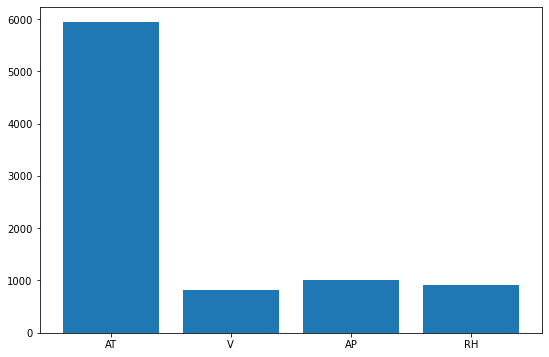

In [62]:
plt.bar(range(X_train.shape[1]), list(map(lambda t:t[0], mae_diff_dict.values())))
plt.xticks(range(X_train.shape[1]), mae_diff_dict.keys())

The graph above replicates the RF feature importance report and confirms our initial assumption: **the `Ambient Temperature` (AT) is the most important and correlated feature to predict electrical energy output** (PE). Despite `Exhaust Vacuum` (V) and AT showed a similar and high correlation relationship with PE (<font color='brown'>respectively 0.87 and 0.95</font>), they have a different impact at the prediction stage. **This phenomenon is a soft example of how not always a high correlation** (<font color='brown'>in Pearson term</font>) **is synonymous of high explainability power**.

## <font color='darkblue'>CAUSATION RELATIONSHIPS</font>
Prove correlation, in order to avoid [spurious relationships](https://www.tylervigen.com/spurious-correlations), is always an insidious operation. At the same time, it is difficult to show evidence of casualty behaviors. In literature, there are a lot of methods to prove causality. One of the most important is the [**Granger Causality Test**](https://en.wikipedia.org/wiki/Granger_causality). This technique is widely applied in time series domain for determining whether one-time series is useful in forecasting another: i.e. demonstrate (<font color='brown'>according to an F-test on lagged values</font>) that it adds explanatory power to the regression.

Indirectly this is what we have already done computing Permutation Importance. Shuffling every variable and looking for performance variations, we are proving how much explicative power has this feature to predict the desired target.

**In order to prove causation, what we have to do now is to demonstrate that the data shuffle provides significative evidence in performance variation.** We operate on the final predictions, achieved without and with shuffle, and verify if there is a difference in mean among the two prediction population. It means that the mean predictions with shuffle might as well be observed by any random subgroup of predictions. **So that’s exactly what we’ll do for every feature: we’ll merge prediction with and without permutation, we’ll randomly sample a group of predictions and calculate the difference between their mean value and the mean values of the prediction without shuffle.**
```python
np.random.seed(33)
id_ = 0 #feature index
merge_pred = np.hstack([shuff_pred[id_], real_pred])
observed_diff = abs(shuff_pred[id_].mean() - merge_pred.mean())
extreme_values = []
sample_d = []
for _ in range(10000):
    sample_mean = np.random.choice(merge_pred,
                  size=shuff_pred[id_].shape[0]).mean()
    sample_diff = abs(sample_mean - merge_pred.mean())
    sample_d.append(sample_diff)
    extreme_values.append(sample_diff >= observed_diff)
    
np.sum(extreme_values)/10000 #p-value
```

In order to have all under control, it’s a good choice to visualize the results of our simulations. We plot the distribution of the simulated mean differences (blue bar) and mark the real observed difference (red line). We can see that for `AT` there is evidence for a difference in mean with the prediction made without shuffle (<font color='brown'>low [**p-value**](https://en.wikipedia.org/wiki/P-value): below 0.1</font>). The other variables don’t bring a significant improvement in the mean.
![a](https://miro.medium.com/max/700/1*mHrDvp8RK7o_HF-SeO9R2w.png)

**Correlation doesn’t always imply causation! With this in mind, we proved causation in terms of the ability of a selected feature to add explicative power.** We’ve recreated, with our knowledge of statistician and programmer, a way to prove this concept making use of our previous findings made with permutation importance, adding information about the relationships of our variables.

## <font color='darkblue'>Scikit-learn Permutation Importance</font>
You can also leverage [**scikit-learn API**](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) to calculate feature importance:

In [63]:
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import plt

# perform permutation importance
results = permutation_importance(model, X_test_scaled, y_test_stdzed, scoring='neg_mean_squared_error')

# get importance
importance = results.importances_mean

# summarize feature importance
for i, v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 7.85754
Feature: 1, Score: -0.24419
Feature: 2, Score: 0.68341
Feature: 3, Score: 0.88903


([<matplotlib.axis.XTick at 0x1e0390ca898>,
 [Text(0, 0, 'AT'), Text(0, 0, 'V'), Text(0, 0, 'AP'), Text(0, 0, 'RH')])

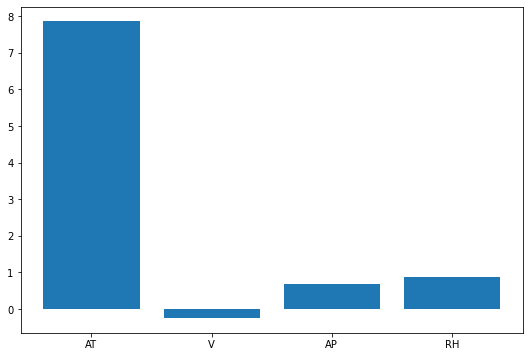

In [65]:
# plot feature importance
plt.bar(range(X_train.shape[1]), importance)
plt.xticks(range(X_train.shape[1]), mae_diff_dict.keys())

## <font color='darkblue'>SUMMARY</font>
In this post, I’ve introduced Permutation Importance, an easy and clever technique to compute feature importance. It’s useful with every kind of model (<font color='brown'>I use Neural Net only as a personal choice</font>) and in every problem (<font color='brown'>an analog procedure is applicable in a classification task: remember to choose an adequate loss measure when computing permutation importance, like cross-entropy, avoiding the ambiguous accuracy</font>). We’ve also used the permutations to present a method that proves casualty among variables hacking the p-value!

## <font color='darkblue'>Supplement</font>
* [Using neural network to calculate feature importance](https://www.kaggle.com/anycode/feature-importance-using-nn)
* [How to Calculate Feature Importance With Python](https://machinelearningmastery.com/calculate-feature-importance-with-python/)